In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt

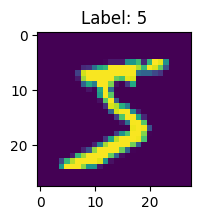

In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

# X_train = (X_train - X_train.mean())/ X_train.std()
plt.figure(figsize=(2,2))
plt.title(f'Label: {Y_train[0]}')
plt.imshow(X_train[0])

In [99]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(1, 6, kernel_size=(5, 5), padding=(2, 2)),
      nn.LeakyReLU(),
      nn.MaxPool2d(kernel_size=(2, 2)),
      nn.Conv2d(6, 16, kernel_size=(5, 5)),
      nn.LeakyReLU(),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.linear = nn.Sequential(
      nn.Linear(16*5*5, 120),
      nn.LeakyReLU(),
      nn.Linear(120, 84),
      nn.LeakyReLU(),
      nn.Linear(84, 10)
    )

    self.means = []
    self.stds = []

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, 1)
    x = self.linear(x)
    return x

Loss: 0.084, Accuracy: 0.979: 100%|██████████| 1000/1000 [02:21<00:00,  7.07it/s]


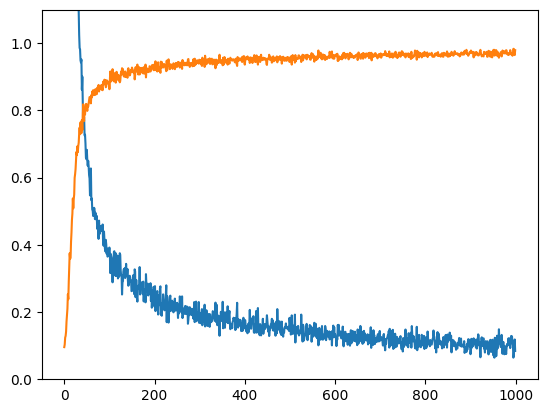

In [111]:
model = LeNet5()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
BS = 1024
EPOCHS = 1000
losses, accuracies = [], []
means, stds = [], []
for i in (t:=trange(EPOCHS)):
  model.zero_grad()

  idx = torch.randint(0, X_train.shape[0], size=(BS, ))
  X = torch.tensor(X_train[idx], dtype=torch.float).reshape(BS, 1, 28, 28)
  y = torch.tensor(Y_train[idx], dtype=torch.long)

  output = model(X)
  loss = criterion(output, y)
  loss.backward()
  optimizer.step()

  accuracy = (torch.argmax(output, dim=1) == y).float().mean()
  accuracies.append(accuracy.item())
  losses.append(loss.item())
  t.set_description(f"Loss: {loss.item():.3f}, Accuracy: {accuracy.item():.3f}")

plt.ylim(0, 1.1)
plt.plot(losses);
plt.plot(accuracies);


In [112]:
#evaluation
X_test_ = torch.tensor(X_test, dtype=torch.float).reshape(-1, 1, 28, 28)
Y_test_ = torch.tensor(Y_test, dtype=torch.long)
output = model(X_test_)
accuracy = (torch.argmax(output, dim=1) == Y_test_).float().mean()
print(accuracy)

tensor(0.9699)
